# Clustering Sura 1, Aya 1
Version: 11.03.2025  
by: Thomas Jurczyk  

This notebook includes:

1. An overview and exploratory data analysis of the subchapter data that should be clustered.
2. The retrieval of document embeddings for each subchapter.
3. Clustering of the documents using the retrieved embeddings.

In [139]:
# imports
import os
import pickle 
import matplotlib.pyplot as plt
import re
import pandas as pd
from mistralai import Mistral
from dotenv import load_dotenv
import psycopg2
from psycopg2 import sql
import numpy as np
import umap
from sklearn.cluster import HDBSCAN
from typing import Optional
import requests

# Apply a style
plt.style.use('ggplot')

# Loading all env variables from .env
load_dotenv()

MISTRAL_API_KEY = os.getenv("MISTRAL_API_KEY")

# Loading params for DB connection to local PostgreSQL

db_params = {
    "host": "localhost",
    "port": "5432",
    "database": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USERNAME"),
    "password": os.getenv("DB_PASSWORD")
}

## Data
The data consists of subchapters from the A01 tafsir corpus that include a discussion of the first aya of the first sura. Note that some chapters do not only discuss the first aya but are subchapters discussing multiple ayat.

### Tokens per subchapter
Next, we count the number of tokens in each subchapter and compare the results with each other. A token is simply defined by at least one blank space separating the tokens. The tokens are not cleaned of non-Arabic characters and still include punctuation marks as well (these might in some cases count as separate tokens as well due to the way the data was collected and reconstructed).

In [ ]:
token_counter = dict()
for filename in os.listdir("data"):
    with open(f"data/{filename}", "r", encoding="utf-8") as f:
        text = f.read()
        tokens = re.split(r"\s+", text)
        token_counter[filename[:-4]] = len(tokens)

In [ ]:
df = pd.DataFrame.from_dict(token_counter, orient="index").reset_index()

In [ ]:
df.columns = ["id", "token_count"]

In [ ]:
df.describe()

In [ ]:
df["token_count"].plot(kind="box", title="Token distribution in subchapters", color="skyblue")

plt.savefig("images/boxplot.jpg")

In [ ]:
# show outliers
df.sort_values("token_count")

### Comparison of one aya vs. multi ayat subchapters

In [ ]:
# First, we annotate the subchapters as multi ayat (1) or single ayat (0)

In [ ]:
df["multi_ayat"] = df["id"].map(lambda x: "multi_ayat" if x.split("_")[-1] != "1" else "single_aya")

In [ ]:
# Creating stats for both subsets

In [ ]:
ax = df.groupby("multi_ayat")["token_count"].median().plot(kind="bar", title="Median token count single/multi ayat", color="skyblue")
# Display count on top of each bar
for bar in ax.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.ylim(0,2000)

plt.tight_layout()

plt.savefig("images/median_mayat.jpg")

In [ ]:
ax = df.groupby("multi_ayat")["token_count"].mean().plot(kind="bar", title="Mean token count single/multi ayat", color="skyblue")
# Display count on top of each bar
for bar in ax.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

plt.ylim(0,5500)

plt.tight_layout()

plt.savefig("images/mean_mayat.jpg")

### Ayat discussed in the subchapters
The following diagram and dictionary demonstrates how often the firrst ayat from the first sura are discussed in the subchapter corpus.

In [ ]:
ayat_counter = {
    1: 0,
    2: 0,
    3: 0,
    4: 0,
    5: 0,
    6: 0,
    7: 0
}

for filename in os.listdir("data"):
    tmp_ls = filename.split("_")[-2:]
    tmp_ls[1] = tmp_ls[1].split(".")[0]
    tmp_ls[0], tmp_ls[1] = int(tmp_ls[0]), int(tmp_ls[1])
    # Increasing ayat counter
    for i in range(tmp_ls[0], tmp_ls[1]+1):
        ayat_counter[i] += 1

In [ ]:
# Extract keys and values
categories = list(ayat_counter.keys())
values = list(ayat_counter.values())

# Create the bar plot
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, values, color='skyblue')

# Display count on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

# Add title and labels
plt.title('Ayat distribution in first subchapter')
plt.xlabel('Ayat')
plt.ylabel('Count')

# Tight layout
plt.tight_layout()

# Save plot
plt.savefig("images/subchapters.jpg")

## Embeddings
In a first step, we are acquiring the embeddings using Mistral's `mistral-embed` model.

We are creating three lists for the text ids, texts, and the embeddings.

In [ ]:
sc_id_list = []
sc_text_list = []
sc_embeddings_list = []

In [ ]:
# Loading texts and ids from drive
for filename in os.listdir("data"):
    with open(f"data/{filename}", "r", encoding="utf-8") as f:
        text = f.read()
        sc_id_list.append(filename[:-4])
        sc_text_list.append(text)

Now, we are retrieving the embeddings for each text and store them in the respective list.  
**Important**: The embeddings are afterwards stored in a database and locally on the computer. Therefore, this step only needs to be executed when something has changed.

In [ ]:
import time

model = "mistral-embed"
execute = False
client = Mistral(api_key=MISTRAL_API_KEY)

# The max token per batch is 16384 or sometimes even lower for some reason (?)
# We split longer texts into chunks
# Using a sliding window approach with an overlap of 50 tokens
# We also need to use time.sleep() to avoid exceeding rate limits with 6 requests per sec
if execute:
    for idx, text in enumerate(sc_text_list):
        #print(f"{idx}. {sc_id_list[idx]}")
        tokens = re.split(r"\s+", text)
        if len(tokens) > 1000:
            #print(f"Text {sc_id_list[idx]} is too long: {len(tokens)}") 
            tmp_embeddings = list()
            # Splitting the text into chunks
            window_size = 500
            stride = 450 # Overlap of 50 tokens
            for start_idx in range(0,len(tokens), stride):
                end_idx = min(start_idx + window_size, len(tokens))
                tmp_text = " ".join(tokens[start_idx:end_idx])
                res = client.embeddings.create(model=model, inputs=[tmp_text])
                tmp_embeddings.append(res.data[0].embedding)
                time.sleep(0.1)
            # Calculate mean from all chunk embeddings
            sc_embeddings_list.append(np.mean(tmp_embeddings, axis=0).tolist())
        else:
            res = client.embeddings.create(model=model, inputs=[text])
            sc_embeddings_list.append(res.data[0].embedding)
            time.sleep(0.1)

In [ ]:
# Saving embeddings locally

with open("mistral_embeddings_full.pkl", "wb") as f:
    #pickle.dump(sc_embeddings_list, f)

In [ ]:
# Reload embeddings
with open("mistral_embeddings_full.pkl", "rb") as f:
    loaded_embeddings = pickle.load(f)

In [ ]:
# Connecting to PostgreSQL and storing embeddings in table

In [ ]:
try:
    conn = psycopg2.connect(**db_params)
    cursor = conn.cursor()
    print("Connection to DB was successful!!")

    for idx, value in enumerate(loaded_embeddings):
        cursor.execute("""
            INSERT INTO embedding.sc_mistral_fulltext (subchapter_id, embedding) 
            VALUES (%s, %s)
        """, (sc_id_list[idx], value))
    
        # Änderungen bestätigen
        conn.commit()
    print("Data was added!")

except Exception as e:
    print(f"Error: {e}")
    if conn:
        conn.rollback()
finally:
    # Close connection
    if cursor:
        cursor.close()
    if conn:
        conn.close()
    print("DB connection closed.")

### Test embeddings for Arabic texts: MSA
We will try and cluster simple Arabic texts to see if this even works.

In [ ]:
# Loading test data
df_test = pd.read_csv("arabic-test-data.csv")

In [ ]:
df_test.head()

In [ ]:
text_list = df_test["arabic_text"].tolist()

In [ ]:
text_list

In [ ]:
# Get embeddings
model = "mistral-embed"

client = Mistral(api_key=MISTRAL_API_KEY)

embeddings_batch_response = client.embeddings.create(
    model=model,
    inputs=text_list,
)

In [ ]:
embeddings_test = [entry.embedding for entry in embeddings_batch_response.data]

In [ ]:
embeddings_test[0][:10]

In [ ]:
# Add embeddings to database
db_test_params = {
    "host": "localhost",
    "port": "5432",
    "database": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USERNAME"),
    "password": os.getenv("DB_PASSWORD")
}

try:
    conn = psycopg2.connect(**db_test_params)
    cursor = conn.cursor()
    print("Connection to DB was successful!!")

    for idx, row in df_test.iterrows():
        cursor.execute("""
            INSERT INTO embedding.test_embeddings (id, embedding, category, translation) 
            VALUES (%s, %s, %s, %s)
        """, (idx, embeddings_test[idx], row["category"], row["translation"]))
    
        # Änderungen bestätigen
        conn.commit()
    print("Data was added!")

except Exception as e:
    print(f"Error: {e}")
    if conn:
        conn.rollback()
finally:
    # Close connection
    if cursor:
        cursor.close()
    if conn:
        conn.close()
    print("DB connection closed.")

### Test embeddings for Arabic texts: Classical Arabic
We will try and cluster classical Arabic texts to see if this even works.

In [ ]:
# Loading test data
df_test = pd.read_csv("classical-arabic-testdata.csv")

In [ ]:
df_test.head()

In [ ]:
text_list = df_test["Arabic_Text"].tolist()

In [ ]:
text_list[:3]

In [ ]:
# Get embeddings
model = "mistral-embed"

client = Mistral(api_key=MISTRAL_API_KEY)

embeddings_batch_response = client.embeddings.create(
    model=model,
    inputs=text_list,
)

In [ ]:
embeddings_test = [entry.embedding for entry in embeddings_batch_response.data]

In [ ]:
# Add embeddings to database
db_test_params = {
    "host": "localhost",
    "port": "5432",
    "database": os.getenv("DB_NAME"),
    "user": os.getenv("DB_USERNAME"),
    "password": os.getenv("DB_PASSWORD")
}

try:
    conn = psycopg2.connect(**db_test_params)
    cursor = conn.cursor()
    print("Connection to DB was successful!!")

    for idx, row in df_test.iterrows():
        cursor.execute("""
            INSERT INTO embedding.test_embeddings_classical (id, embedding, category, translation) 
            VALUES (%s, %s, %s, %s)
        """, (idx, embeddings_test[idx], row["Category"], row["English_Translation"]))
    
        # Änderungen bestätigen
        conn.commit()
    print("Data was added!")

except Exception as e:
    print(f"Error: {e}")
    if conn:
        conn.rollback()
finally:
    # Close connection
    if cursor:
        cursor.close()
    if conn:
        conn.close()
    print("DB connection closed.")

## Dimensionality Reduction & Clustering
For easier plotting and comparison, we reduce the 1024 features from Mistral's embeddings to 2 features. We will be using umap for the dimensionality reduction.

First, we load the stored Mistral AI embeddings and the subchapter corpus.

In [166]:
# Load embeddings
loaded_embeddings = []
with open("mistral_embeddings_full.pkl", "rb") as f:
    loaded_embeddings = pickle.load(f)

In [167]:
# Loading texts and ids from drive
sc_dict = dict()
for idx,filename in enumerate(os.listdir("data")):
    with open(f"data/{filename}", "r", encoding="utf-8") as f:
        text = f.read()
        sc_dict[filename[:-4]] = {"embedding": loaded_embeddings[idx]}

df = pd.DataFrame.from_dict(sc_dict, orient="index")

If we want, we can further filter the subchapter corpus, for instance by only selecting subchapters that discuss exactly one aya.

In [168]:
# Only 1 aya suras (optional)
#df = df[df.index.str.endswith("_1")]
# Only suras that discuss more than one sura (optional)
#df = df[~df.index.str.endswith("_1")]

In [169]:
df

,embedding
sc.75_1_1_1,"[-0.0276947021484375, 0.0301513671875, 0.05911..."
sc.92_1_1_1,"[-0.015995388939267115, 0.037729899088541664, ..."
sc.26_1_1_1,"[-0.0121002197265625, 0.050140380859375, 0.065..."
sc.68_1_1_7,"[-0.023973177557122218, 0.03675131601830051, 0..."
sc.79_1_1_1,"[-0.0017709732055664062, 0.041717529296875, 0...."
...,...
sc.9_1_1_1,"[-0.026764488220214842, 0.03731479644775391, 0..."
sc.84_1_1_1,"[-0.02484130859375, 0.03887939453125, 0.060943..."
sc.47_1_1_1,"[-0.015649159749348957, 0.044352213541666664, ..."
sc.105_1_1_1,"[-0.019561767578125, 0.0380859375, 0.058227539..."


Next, we apply umap on the np.array version of the embeddings.

In [170]:
# First convert all lists to np.arrays, otherwise umap won't work
embeddings_orig = df["embedding"].to_numpy()
embeddings_orig = [np.array(l) for l in embeddings_orig]

In [171]:
umap_reducer = umap.UMAP(n_neighbors=2, 
                         min_dist=0.1, 
                         n_components=2,
                         #metric="cosine",
                         random_state=42)

In [172]:
embeddings_reduced = umap_reducer.fit_transform(embeddings_orig)

/home/tommy/environments/a01/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tommy/environments/a01/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Next, we are using HDBSCAN to cluster the data.

In [173]:
hdbscan_clusterer = HDBSCAN(min_cluster_size=3, 
                           min_samples=5,
                           cluster_selection_epsilon=0.5)

cluster_labels = hdbscan_clusterer.fit_predict(embeddings_reduced)

Plotting the results.

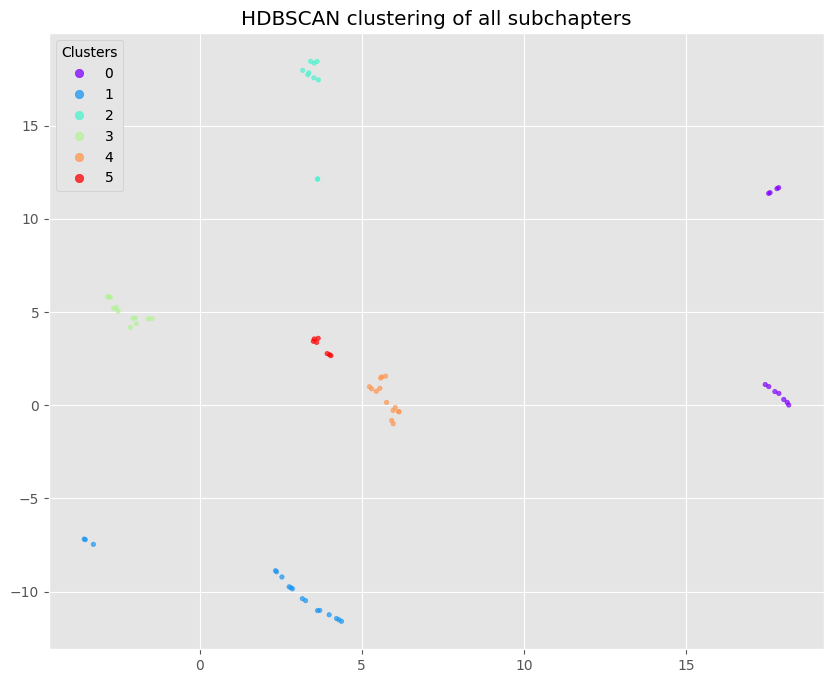

In [174]:
# Plot reduced datapoints
plt.figure(figsize=(10, 8))

# Create scatter plot
scatter = plt.scatter(embeddings_reduced[:, 0], 
            embeddings_reduced[:, 1], 
            c=cluster_labels, 
            cmap='rainbow', 
            s=10, 
            alpha=0.7)

# Add a legend for the clusters
legend1 = plt.legend(*scatter.legend_elements(),
                    title="Clusters")
plt.gca().add_artist(legend1)

# Title
plt.title("HDBSCAN clustering of all subchapters")

# Saving plot
plt.savefig("images/hdbscan_all.jpg")

## Retrieving texts of subchapters in each cluster

In [162]:
def download_subchapter_file(subchapter_id: str, filename: Optional[str] = None):
    # Build API path from sc_id
    # Example: http://localhost:8080/api/download/tafsir/3/c.3_2/sc.3_2_77_77
    url = "http://localhost:8080/api/download/tafsir/"
    sc_list = subchapter_id.split("_")
    tafsir_id = sc_list[0].split(".")[1]
    url += tafsir_id + "/"
    chapter_id = "c." + tafsir_id + "_" + sc_list[1]
    url += chapter_id + "/" + subchapter_id
    # DEBUG
    print(url)
    # Anfrage an die URL senden
    response = requests.get(url)
    
    # Überprüfen, ob die Anfrage erfolgreich war
    response.raise_for_status()
    
    # Datei speichern
    with open(filename, 'wb') as file:
        file.write(response.content)
    
    return filename

In [163]:
def download_cluster_subchapters(subchapter_list: list[str], path: str):
        if not os.path.exists(path):
            os.makedirs(path)
            print(f"Directory created: {path}")
        else:
            print(f"Directory already exists: {path}")
        for sc in subchapter_list:
            download_subchapter_file(sc, f"{path}/{sc}.txt")

In [165]:
download_cluster_subchapters(df[cluster_labels==1].index.tolist(), "clustering/sc1-7/1")

Directory created: clustering/sc1-7/1
http://localhost:8080/api/download/tafsir/14/c.14_1/sc.14_1_1_7
http://localhost:8080/api/download/tafsir/65/c.65_1/sc.65_1_1_7
http://localhost:8080/api/download/tafsir/88/c.88_1/sc.88_1_1_7
http://localhost:8080/api/download/tafsir/28/c.28_1/sc.28_1_1_7
http://localhost:8080/api/download/tafsir/37/c.37_1/sc.37_1_1_4
http://localhost:8080/api/download/tafsir/100/c.100_1/sc.100_1_1_6
http://localhost:8080/api/download/tafsir/83/c.83_1/sc.83_1_1_7
http://localhost:8080/api/download/tafsir/103/c.103_1/sc.103_1_1_7
http://localhost:8080/api/download/tafsir/13/c.13_1/sc.13_1_1_7
http://localhost:8080/api/download/tafsir/60/c.60_1/sc.60_1_1_4
http://localhost:8080/api/download/tafsir/104/c.104_1/sc.104_1_1_7
http://localhost:8080/api/download/tafsir/52/c.52_1/sc.52_1_1_7
http://localhost:8080/api/download/tafsir/98/c.98_1/sc.98_1_1_7
http://localhost:8080/api/download/tafsir/67/c.67_1/sc.67_1_1_4
